This notebook illustrates how to use scikit-bio's global aligner to perform progressive multiple sequence alignment. The concept is discussed in more detail in the Multiple Sequence Alignment chapter of [An Introduction to Applied Bioinformatics](http://readiab.org/).

First, we'll load up some sequence from the [Greengenes 13_5](http://www.ncbi.nlm.nih.gov/pubmed/22134646) 61% OTUs.

**NOTE: for the sake of runtime, I'm currently computing the alignment from only the first ``slice_length`` bases of the sequences.** This results in our final tree being pretty terrible in this example. For a better tree (and longer run time) increase the value of the ``slice_length`` variable.

In [1]:
import collections
import io

import skbio.io
from skbio import DNA

slice_length = 100
display_tax_levels = 2

fasta = io.StringIO(""">229854
GAGTTTGATCCTGGCTCAGATTGAACGCTGGCGGCATGCTTAACACATGCAAGTCGAACGGCAGCATGACTTAGCTTGCTAAGTTGATGGCGAGTGGCGAACGGGTGAGTAACGCGTAGGAATATGCCTTAAAGAGGGGGACAACTTGGGGAAACTCAAGCTAATACCGCATAAACTCTTCGGAGAAAAGCTGGGGACTTTCGAGCCTGGCGCTTTAAGATTAGCCTGCGTCCGATTAGCTAGTTGGTAGGGTAAAGGCCTACCAAGGCGACGATCAGTAGCTGGTCTGAGAGGATGACCAGCCACACTGGAACTGAGACACGGTCCAGACTCCTACGGGAGGCAGCAGTGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCAATGCCGCGTGTGTGAAGAAGGCCTGAGGGTTGTAAAGCACTTTCAGTGGGGAGGAGGGTTTCCCGGTTAAGAGCTAGGGGCATTGGACGTTACCCACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCCGCGGTAATACGGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCCGTTAAAAGGTGCCTAAGGTGGTTTGGATAGTTATGTGTTAAATTCCCTGGCGCCTCCACCCTGGGCCAGGTCCATATAAAAACTGTTAAACTCCGAAGTATGGGCACAAGGTAATTGGAAATTCCGGTGGTACCGTGAAAATGCGCTTAGAGATCGGGAAGGGACCACCCCAGTGGGGAAGGCGGCTACCTGGCCTAATAACTGACATTGAGGCACGAAAAGCGTGGGGAGCAACCAGGATTAGATACCCTGGTAGTCCACGCTGTAAACGATGTCAACTAGCTGTGGTTATATGAATATAATTAGTGGCGAAGCTAACGCGATAAGTTGACCGCCTGGGGAGTACGGTCGCAAGATTAAAACTCAAAGGAATGACGGGGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTACCCTTGACATACAGTAAATCTTTCAGAGATGAGAGAGTGCCTTCGGGAATACTGATACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGTAACGAGCGCAACCCTTATCTCTAGTTGCCAGCGAGTAATGTCGGGAACTCTAAAGAGACTGCCGGTGACAAACCGGAGGAAGGCGGGGACGACGTCAAGTCATCATGGCCCTTACGGGTAGGGCTACACACGTGCTACAATGGCCGATACAGAGGGGCGCGAAGGAGCGATCTGGAGCAAATCTTATAAAGTCGGTCGTAGTCCGGATTGGAGTCTGCAACTCGACTCCATGAAGTCGGAATCGCTAGTAATCGCGAATCAGCATGTCGCGGTGAATACGTTCCCGGGCCTTGTACACACCGCCCGTCACACCATGGGAGTGGGCTGCACCAGAAGTAGATAGTCTAACCGCAAGGGGGACGTTTACCACGGTGTGGTTCATGACTGGGGTGAAGTCGTAACAAGGTAGCCG
>2107103
TTTTCTTGGATTTGATTCTGGTCCAGAGTAAACGCTTGAGATATGTTGATACATGTTAGTTAAACGTGAATATTTGGTTTTTATGCCAACTTTATTTAAGTAGCGTATAGGTGAGTAATATGCAAGAATCCTACCTTTTAGTTTATGTAGCTCGTAAATTTATAAAAGATTTTTTCGCTAAAAGATGGGCTTGCACAAGATTAGGTTTTTGGTTTGCTAAAAACGTTCCAAGCCTAAGATCTTTAGCCGGCTTTCGTGAGTGACCGGCCACATAGGGACTGAGACAATGCCCTAGCTCCTTTTCTGGAGGCATCAGTACAAAGCATTGGACAATGAACGAAAGTTTGATCCAGTAATATCTCGTGAATGATGAAGGGTTTTTGCTCGTAAATTTCTTTTAGTTGAAAGAAAAAAGATATATTTCAACAGAAAAAATCCTGGCAAATCCTCGTGCCAGCAGCCGCGGTAATACGAGAAGGGTTAGCGTTACTCGAAATTATTGGGCGTAAAGTGCGTGAACAGCTGCTTTTTAAGCTATAGGCAGAAAAATCAAGGGTTAATCTTGTTTTTGTCATAGTTCTGATAAGCTTGAGTTTGGAAGAAGATAATAGAACATTTTATGGAGCGATGAAATGCTATGATATAAAAGAGAATACCAAAAGCGAAGGCAGTTATCTAGTACAAAACTGACGCCTATACGCGAAGGCTTAGGTAGCAAAAAGGATTAGGGACCCTTGTAGTCTAAGCTGTCAACGATGAACACTCGTTTTTGGATCACTTTTTTTCAGAAACTAAGCTAACGCGTTAAGTGTTTCGCCTGGGTACTACGGTCGCAAGACTAAAACTTAAAGAAATTGGCGGGAGTAAAAACAAGCAGTGGAGCGTGTGGTTTAATTCGATAGTACACGCAAATCTTACCATTACTTGACTCAAACATTGAAATGCACTATGTTTATGGTGTTGTTTAAGTATTATTTTACTTATAGATGTGCAGGCGCTGCATGGTTGTCGTCAGTTCGTGTCGTGAGATGTTTGGTTAATTCCCTTAACGAACGTAACCCTCAAAGCATATTCAAAACATTTTGTTTTTTTGTTAAACAGTCGGGGAAACCTGAATGTAGAGGGGTAGACGTCTAAATCTTTATGGCCCTTATGTATTTGGGCTACTCATGCGCTACAATGGGTGTATTCTACAAAAAGACGCAAAAACTCTTCAGTTTGAGCAAAACTTGAAAAGCACCCTCTAGTTCGGATTGAACTCTGGAACTCGAGTTCATAAAGTTGGAATTGCTAGTAATCGTGAGTTAGCGTATCGCGGTGAATCGAAAATTTACTTTGTACATACCGCCCGTCAAGTACTGAAAATTTGTATTGCAAGAAATTTTTGGAGAATTTACTTAACTCTTTTTTTTTTTAAGTTGGCTGTATCAGTCTTTTAAAAACTTTGAGTTAGGTTTTAAGCATCCGAGGGTAAAAGCAACATTTTTTATTGGTATTAAGTCGTAACAAGGTAGCCCTACGGG
>696036
AGAGTTTGATCATGGCTCAGGATGAACGTTGGTAGTATGCCTAACACATGCAAGTCGAGCGGAAAGTAGTAGCAATATTACCTTTAGCGGCGAACGGGTGAGTAATACTTATCTTACCTGCCATTTAGTGGGGGATAAAATTCCGCATATTATGAGTAATCATGAAAGGGCTTTCGGGCTCGCTAATTGATGGGGATAAGTCGTATTAGTTAGTTGGTGGGGTAATGGCCTACCAAGACAATGATGCGTAGCCAGTCTGAGAGGATGAATGGCCACAAAGGAACTGAGACACGGTCCTTACTCCTATTGAGGAGGCAGCAGTGGGGAATATTCTGCAATGGGGGAAACCCTGACAGAGCAATACTACGTGAAGGAGGAAGGTCTACGGATTGTAAACTTCTTTACTTAAATGTACTAACCGCAAGGTTTTGCATTTGAGCAAAAAGCGACGACTAACTATGTGCCAGCAGTCGCGGTAAGACATAGGTCGCGAACGTTATCCGGAATTATTGGGCGTAAAGGATGCGTAGATGGTTCAGTAAGTTACTGGTGGGAAATCGAGGCCTAACCTCGTGGAAGTCAGTAATACTGTTGAACTTGAGTGCAGGAGAGGTTAACGGAACTTCATGTGGAGCGGTAAAATGCGTAGATATATGAAAGAACATCAATATAGCGAAGGCAGTTAACTATTCTGCTACTGACATTGAGGCATGAAAGCGTGGGGAGCAAAACGGATTAGATACCCGTGTAGTCCACGCCCTAAACGATGAGTGCTAGATATTGGGAACTTGATTCTCAGTGTCGCTAGGTAACCCGGTAAGCACTCCGCCTGGGGAGTACGCTCGCAAGAGTGAAACTTAAAGGAATTGACGGGGACTCGCACAAGCAGTGGAGCATGTGGTTTAATCCGATACAACGCGTAGAACCTTACCAAGGCTTGACATGTAAGGTAGCAATACTAAATTAGGGAAACCTAGTTGAATTACACAGGTGCTGCATGGCCGTCGTCAGTTCGTGCCGTGAGGTGTATGGTTAAGTCCTATAACGAACGCAACCCTTGTCCTTAGTTGCCAGCATTCAGTTGGGGACTCTAAGGAGACTGCAAGGCATGTTTATGCATGTCTGAACTGAGTAATCAGGAGGAAGGAAAGGATGACGCCTGGTCGTCATGGCCCTTATGCCTTGGGCGACACACGTGCTACAATGGTTAGTACAAAGGGTCGCCAACCCGCGAGGGGGAGCTAATCTCAAAAAACTAACCGCAGTTCAGATTGGAGGCTGCAACTCGCCTCCATGAAGGTGGAATTGCTAGTAATCGTAAATCAGCCATGTTACGGTGAATACGTTCTCGAGTCTTGTACACACCGCCCGTCAAATCACGAAAGTCGGTAATGCCTAAAACCAGTTGATTAACCCGCAAGGGATACAGCTGACAAGGGTAGGATTGGCAATTGGGGTTAAGTCGTAACAAGGTAGCCGTAG
>3190878
TTAATACATGCGAGTTGAACGTGAATTTTTTAATTAAAATGAAAGTAGCGTACTGGTGAGTAACACGTGAGAATCTACCTTTCAAATCAACATAAAATGTTGAATAAAAGCTTCTAAAGCTATAAAGATATGTTTTCGTTGAAAGATGAGCTTGCGCAAGATTAGGTAGTTGGTAAGGTAACGGCTTACCAAGCCAAAGATCTTTAGCTGGTTTGAGAAAATGATCAGCCACATTGGAACTGAAACACAGTCCAAACGTAATATAACGGCAGCAGTAGGGAATTTTGAACACTGAGCGAAAGCTTGATTCAGCCAAGTATCGTGGATGAAGAAGGCTGTCTTTTGGTCGTAAAATCCATTTATATAGTCACATGAAATGTGTCTTTTATTTCGATAAAAGGAAAGATTATGACTTTCTATTGAAAAGTCCCGGCTAATCTCGTGCCAGCAGCCGCGGTAATACGAGAGGGGCAAACGATGTTTAGCATGATTGGGCGTAAAGAGCTTGTAGATGGTTTCTTTTAATTTTATATAAAAGCTCTAAGCTTAACTTTGATTATATATAAAGGAAAGATAACTTGAGTTATGGAAAGGAAAGTAGAATTCTTGGAGGAGAGGTAGAATTTGGTGATATCAAGAGGAATTCCAAAAGCGAAGGCAGCTTTCTTGCCATATACTGACATTGAAGGGCGAAAGCGTGGGTAGCGACAGGGATTAGATACCCCATTAGTCCACGCCGTCAACGATGACCTTTATTTATTGGTTTCTCTTAAAATAAATAAATTATTTTTTAGTTTGATCAGTGAAACAGTTAACGCGTTAAAAGGTCCGCCTGAGGAGTACGATCGCAAGATTAAAACTCAAAAGAATAGACGGGAGCGTTCACAAGTGGTGGAGCATGAAGTTTAATGCGATACAACACGCAAAACCTTACCATTTTTTGATATTTTACTTATCAGTTATTTCTCATGAAATAATGTTTTTTACTAAAGTAAAAATTTGTTTGTATAACAGGCGTTGCATGGCTGTCGTAAGTTCGTACTGTGAAGTGTTGGATTAATTTCCTTAACGAACGTAACCCCTTGGTTTTGTTAAAACTAAAATCTACCGCTAGTCATAAACTAGAGGAAGGGAGGGATCACGTCAAGTCCTCATGACCCTTATAAAATGGGCTACGCTTTTCGTGCTACAATGATAAATACAATAAGAAGCAATAACGAAAGTTGGAGCAAATCTATAAAATTTATCTCAGTTCAGATTGTTCTCTGCAATTCGAGAACATGAAGATGGAATCACTAGTAATCGTAGATCAGCATGCTACGGTGAATATGTAATTACGCTCTGTACTCACAGCCCGTCACACAATGGAAGTAAAATGTATCGGAAATTTGTCAAATATTGTTAGATTTTCTTTTTTAAATTTATTGAATAAATTATTTTAATTAATATCTTTCAACTAAATGGGAACTGATGATATGTTTCATGACTGTTGTGAAGTCGTAACAAGGTAGCGCTAGCGGAAGCTGGTGCTGGAT
>3761685
GATGAACGCTCGCGGCGTGCCTAAGGTATGCAAGTCGAACGCCGACCTTCGGGTCGTGCGTGGCGAACGGGTGAGTAACGCGTGGGAACGTACCGCCGAGATGGGGACAACTCCGCGAAAGCGGAGCTAATACCCAATGGTCCCGGGTCGTACCTCACTGCGTTCGGTACGGATACGATGGACATTCGTATTCCCGCGCCGAGCGTAGCGAGGTGCGACTTGGGTAAAGGAGCAATCCGCTCGGTGAGCGGCCCGCGTCCTATCAGCTTGTTGGTGGGGTAATGGCCTACCAAGGCGATGACGGGTAGGGGGTGTGAGAGCATGATCCCCCACAATGGCACTGAGACAAGGGCCATACACCTACGGGTGGCAGCAATCAGGAATCTTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGCGTGGAGGATGAAGGTCGAGAGATTGTAAACTCCTAGCCTTGTGCGTAGCACAAGGGGTTCGTATATCGTTAGTCGGTTACGAAGCCCGTATCGTAAGGCGGTTACGGTTACGTGAAAAACACGTAACCCAATCACGTGACCGAAACGGGCATCGTTACCGTAACCGGCAGACGTTTCACGAATCTCTCGTGTTACGCGCGAGGGGATAAAGTCCCGGCTAACTACGTGCCAGCAGCAGCGGTAAAACGTAGGGGCGAGCGCTATCCGGATTTATTGGGCGTAAAGAGTGCAGGCGCCAGGTTTTTCGTTAAAGCCCCCCGCTCAACGGGGGAACTGCGGAGAATACTGTTTGGCTGGAGGAAGGTAGAGGCTGTCGGAACTCGGGGAGGAGGGGTGAAATCCTATGATCCCCCAAGGAACACCAAAGGCGAAGGCAGACAGCTGGGCCTTTCCTGACGCTGAGGCACGAAAGCTAGGGGAGCGAAACGGATTAGATACCCGTGTAGTCCTAGCCGTAAACGATCCCCGCTAGATTTTGGCATCTGTCAGAGTCGAAGCTAACGCATTAAGCGGGGCGCCTGGGAAGTACGGCCGCAAGGCTAAAACTCAAAGGAATTGACGGGGACCCGCACAAGCGGTGGAGCGCCTGGTTTAATTCGATGATAACCGAAGAACCTTACCAGGGCTTGACATCCCGACAGAAATCCCGACGAAAGTTGGGCCCCCCGCAAGGGCTGTCGGGACAGGTGTTGCATGGCTGTCGTCAGCTCGTGCCGTGAGGTGTATGCTTAAGTGCCGAAACGAGCGCAACCCCTACCCCATGTTAGAAATGTCGTGGGGGACTGCCTCCGTAAGGGGGAGGAAGGTGGGGACGACGTCAAGTCAGTATGGCCCTTATGCCCTGGGCAACACAGACGCTACAATGGCGGCTACAACGGGTTGCAATGTCGTAAGGCGGAGCTAATCCTAAAAAGCCGTCTCAGTTCGGATTGGGGGCTGAAACCCGCCCCCATGAAGTTGGAATCGCTAGTAATGGCCGGTCAGCTATACGGCCGTGAATACGTTCTCGGGTCTTGTACACACCGCCCGTCA
>3779572
GGAACAACAACTGGAAACGGTTGCTAATACCCCATAGGCTGAGGAGTCAAAGGAGGAATCTGCCCTAGGAGGGGCTTGCGTCTGATTAGCTTGTTGGTGAGGCAATGGCTTACCAAGGCAAGGATCAGTAGCTGGTCCGAGAGGATGATCAGCCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGAGGCAGCAGTTTTCCGCAATGGGCGAAAGCCTGACGGAGCAATGCCGCGTGGAGGTTGAGGCCTACGGGTCCCGAACTTCTTTTCTCGGAGAAGAAGCAATGACGGTATCTGAGGAATAAGCATCGGCTAACTCTGTGCCAGTAGCCGCGGTAAGACAGAGGGTGCAAGCGTTATCCGGTAAAGCGTCTGTTAGGTGGCTTTTCAAGTCCTCCGTCAAATCCCAGGGCTCAACCCTGGACAGGCGGTGGAAACTACCAAGCTGGAGTACGGTAGGGGTAGAGGGAACTTCCGGTGAAGCAGTGAAATGCGTTGAGATCGGAAAGAACACCACTGGCGAAAGCACTCTGCTGGACCGACACTGACACTAAAGGACGAAAGCTAGGGGAGCGAATGGGATTAGAGACCCCGATAGTCCTAGCCGTAAACGATGGATACTAGGTGTTGTGCGTATCGACCCGTGCAGTGCTGTAGCTAACGCGTTAAGTATCCCGCCTGGGAAGTATGTTCGCAAGAATGAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAAAGCGGAGAACCTTACCAGGGCTTGACATGTTTTGCGAATCTCTCTTGAAAGAGGGGAGTGCCTTCGGGAACGCGGACACAGGTGGTGCATGGCTGTCGTCAGCTCGTGCCGTAAGGTGTTGAGTTAAGTCTCGCAACGAGCGCAACCCTCGTGTTTAGTTGCCACCATGGATTTTGGAACCCTGAACAGACTGCTGGTGTGAAGCCGGAGGAAGGAGAGGATGACGTCAAGTCCTCATGCCCCTTATGCCCTGGGCGACACGCGTGCTACAATGGGCGGGACAAAGGATCACGATCCCGCGAGGGTGAGCTAACTTGTTCTCAGTTCGGATTGCAGGCTGCAACTCGCCTGCATGAAGCAGGAATCGCTAGTAATCGCCGGTCAGCCATACGGCGGTGAATTCGTTCTCGGGCCTTGTACACACCGCCCGTCACACTAGGGAAGCTGACCATGTCTGAAGTTCTTACCTGAACCGCAAGGAGGGGTATGCCCAAGGCGAGGCTAGTAACCGGAGTGAAGTCGTAACAAGGTAGCCGTACTGGAAGGTGCGGCTGGATTACCTCC
>4251079
AGTGGCGAACGGGTGCGTAACGCGTGGGAATCTGCCGAACAGTTCGGGCCAAATCCTGAATCAAGCTAAAAAGCGCTGTTTGATGAGCCTGCGTAGTATTAGGTAGTTGGTCAGGTAAAGGCTGACCAAGCCAATGATGCTTAGCTGGTCTTTTCGGATGATCAGCCACACTGGGACTGAGACACGGCCCGGACTCCCACGGGGGGCAGCAGTGGGGAATCTTGGACAATGGGCGAAAGCCCGATCCAGCAATATCGCGTGAGTGAAGAAGGGCAATGCCGCTTGTAAAGCTCTTTCGTCGAGTGCGCGATCATGACAGGACTCGAGGAAGAAGCCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAAGACGGGGGGGGCAAGTGTTCTTCGGAATGACTGGGCGTAAAGGGCACGTAGGCGGTGAATCGGGTTGAAAGTTCAAGTCGCCAAAAACTGGCTCCATGCTCTCGAAACCAATTCACTTGAGTGAGACAGAGGAGAGTGGAATTTCGTGTGGAGGGGTGAAATCCGGAGATCTACGAAGGAACGCCAAAAGCGAAGGCAGCTCTCTGGGTCCCTACCGACGCTGGGGTGCGAAAGCATGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCATGCCGTAAACGATGAGTGTTCGCCCTTGGTCTACGCGGATCAGGGGCCCAGCTAACGCGTGAAACACTCCGCCTGGGGAGTACGGTCGCAAGACCGAAACTCAAAGGAATTGACGGGGGCCTGCACAAGCGGTGGAGCATGTGGTTTAATTCGATACAACGCGCAAAACCTTACCAGCCCTTGACATATGAACAAAAAAACCTGTCCTTAACGGGATGGTACTGACTTTCATACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTTGGTCAAGTCCTATAACGAGCGAAACCCTCGTTTTGTGTTGCTGAGACATGCGCCTAAGGAAAAAGTCTTTGCAACCGAAGTGAGCCGAGGAGCCGAGTGACGTGCCAGCGCTACTAATTGAGTGCCAGCACGTAGCTGTGCTGTCAGTAAGAAGGGAGCCGGCGCCTTTCGAAGCACTTTCTAGTGTGAACCGAACGTCCCGCGTTCCGGCTTGTTCGAATCGCGTCACGAGTCTACAAGCCCCACTGATACCTACCTATAGTGACGTCAAAGTACCAGTGACGGTGACTTGGTTGCGTAACGTAATATGGATTCAGTCAGCGAAACTCCCTCCAACTCAATCAATATCAACAACATGTCGTGACGAGCCTGACTACACTCCACCTGACGGTACTACACTATCTATCAGTAGAGCGCCTTGCGCGATACGGCTTTTTGGCCGTATCTTGCAGGTGACGACGACGTCGAGTTGGCGGCGGAGGAAGACTCGGCATTCAGGCGAGCCGCCCGGTGGTGTGGTACGTAGTGGTAATAGTACGCCCCGCCCGTCACACCCTTCAAGCTCCGAAACAAACAAAAAGGTGCGTGCCGCACTCACGAGGGACTTGCCAGTGATATACTGAAGGAAGGTGGGGATGACGTCAAGTCCGCATGGCCCTTATGGGCTGGGCCACACACGTGCTACAATGGCAATTACAATGGGAAGCAAGGCTGTAAGGCGGAGCGAATCCGGAAAGATTGCCTCAGTTCGGATTGTTCTCTGCAACTCGGGAACATGAAGTTGGAATCGCTAGTAATCGCGGATCAGCATGCCGCGGTGAATATGTACCCGGGCCCTGTACACACCGCCCGTCACACCCTGGGAATTGGTTTCGCCCGAAGCATCGGACCAATGATCACCCATTCCTTGTGTGTACCACTAGTGCCACAAAGGCTTTTGGTGGTCTTATTGGCGCATACCACGGTGGGGTCTTCGACTGGGGTGAAGTCGTAACAAGGTAGCCGTAGGGGAACCTGTG
>4336814
ACGCTGGCGGCACGCCTAATACATGCAAGTCGAACGAAGTAGCAATACTTAGCGGCAGACGGGTGAGTAACATGTGGGTATCTTCCCTTTGGTGAGGAATAACACGAGGAAACTTGTGCTAATACCTCATAAGTCTTTACAGAGAAAGCTTTATGCGCCGATGGATGAGCCCGCACTTGATTAGTTTGTTGGTGGGGTAATAGCCTACCAAGACTATGATCAATAGCTGATTTGAGAGGATGATCAGCCACATTGGGACTGAGACACGGCCCAAACTCCTACGGGAGGCAGCAGTAGGGAATCTTGCACAATGGAGGAAACTCTGATGCAGCGATGCCGCGTGAGTGAAGAAGGCCCTTGGGTTGTAAAGCTCTTTCGTCGGGGAAGAAAATGACTGTACCCGAATAAGAAGGTCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGACCTAGCGTAGTTCGGAATTACTGGGCTTAAAGAGTTCGTAGGTGGTTAAAAAAGTTGGTGGTGAAAGCCCAGAGCTTAACTCTGGAACGGCCATCAAAACTTTTTAGCTAGAGTATGATAGAGGAAAGCAGAATTTCTAGTGTAGAGGTGAAATTCGTAGATATTAGAAAGAATACCGATTGCGAAGGCAGCTTTCTGGATCATTACTGACACTGAGGAACGAAAGCATGGGTAGCGAAGAGGATTAGATACCCTCGTAGTCCATGCCGTAAACGATGTGTGTTAGATGTTGGAAATTTATTTTCAGTATCGCAGCGAAAGCAATAAACACACCGCCTGGGGAGTACGACCGCAAGGTTAAAACTCAAATGAATTGACGGGGACCCGCACAAGTAGTGGAGCATGTGGTTTAATTCGAAGATACGCGCAGAACCTTACCAACACTTGACATGTTCGTCGCGACTCTAAGAGATTAGAGTTTTCGGTTCGGCCGGACGAAACACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTCACTTTTAGTTGCTACCATTTAGTTGGGCACTCTGAAAGAACTGCCAGTGATAAGCTGGAGGAAGGTGGGGATGACGTCAAGTCCTCATGGCCCTTACGTGTTGGGCTACACACGTGCTACAATGGGTACACACCGCCCGTCACACCATGGGAGTTGGTTCTACCTTAAGGCAAAGTTTAAAACCTTTGACCACGGTATAGTCAGCGACTGGGGTGAAGTCGTAACAAGGTAGCCGTAGGGGAACCTGCGGCTGGATTACCTCCTTTCT
>4363260
CCTTGGGGAGAATAACAACTGGAAACGGTTGCTAAAACTCCATAAGCTGAGAAGTTAAAGGTTAACACCACCTAAGGATGGGCTTGCGTCTGATTAGCTAGTTGGTAAGGTAATGGCTTACCAAGGCAACGATCAGTAACTGGTCTGAGAGGATGATCAGTCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGAGGCAGCAGTGAGGAATTTTCCGCAATGGGCGAAAGCCTGACGGAGCAATGCCGCGTGGAGGATGACGGCCCGTGGGTTGTAAACTCCTTTTCTTAGAGAAGAAATTTGACGGTATCTAAGGAATAAGCATCGGCTAAATTATTGGCCCCTACATTAGTGATTTTGTAGGTAAACTTGGCTCATAACGGTGAAACCCTAACGCGTCTGCGGTTTATTCTGAATTTTCTAAATTCCGAATTTCCTTTTTCTTTTGAAAAAGGGATGGCGAGGGCAATACCGTGGGAAGTCTATTCAGTGAAAACGTTAGTCAATTCATTAATTTTAACAGACCCGCTAGCGTTATGTTTGGTATTTAGATGACGGTACGAAACGAAGGTACTGAATCTTGTCGAATCGCAACTCAATCTTTTTCTAAAGAGGAACACGAATTGTTACAAAATTGTTTCAAACAAAATTTTAATATATCGGTCCAAATTGAAGATTGGGGAAGAACAAAAGACGGTTCAATTTCTTACTCACTTGCCATTTTAAGTCGAGGAGGAAATTTTAAGAAATTTCGTGATGTTATTTACGATATCGTAAATGCCGAAGTACCAAGCATGCTTTATAAGCTGTAATGACCCCGTAACGACTGAGAAAATGTTTTTTTCGAAAAACAAAGTACGAGATATTTTCTTTGAATAAATAAGAAAGTATAATACGCCGAGCGCTTGATTTCATCATCAAGATGATGGTATAGTCTATGCTCTAGGAAACTAGGGATTATCATGAACTCCGTGCCAGCAGCCGCGGTAAGACGGAGGATGCAAGCGTTATCCGGAATGATTGGGCGTAAAGCGTCTGTAGGTGGTTTTTAAAGTCGAATGTCAAAGATCAGGGCTTAACCCTGATTCGGCATTCGAAACTCAAAAGCTTGAGTTCGGTAGAGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAACGGCGAAAGCACTCTGCTGGGCCGAAACTGACACTCAGAGACGAAAGCTAGGGGAGTGAATAGGATTAGATACCCTAGTAATCCTAGCCGTAAACGATGGATACTAAGCATTGGGCGCTAAAACGTTCGGTGCTGTAGCTAACGCGTTAAGTATCCCGCCTGGGGAGTATGCTCGCAAGAGTGAAACTCAAAGGAATTGACGGGGGCCCGCACAAACGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCAGGGCTTGACATGCTACGCATTCTTTGGAAACAGAGAAGTTCAAACGTAGACACAGGTGGTGCATGGCTGTCGTCAGCTCGTGCCGCGAGGTGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTTATTGTTAGTTGCCATTGGGAAACTAGCAACACTGCCGGTGATAAGCCGGAGGAAGGTGAGGACGACGTCAAGTCATCATGCCCCTTACGCCCTGGGCTACACACGTGCTACAATGGCCAGGACAAAGAGACGCAACCCCGCAAGGGTAAGCTAACCTCAAAAACCTGGTCTCAGTTCGGATTGTAGGCTGCAACTCGCCTACATGAAGCCGGAATCGTTAGTAATCGCCGGTCAGCCATACGGTGGTGAATACGTTCCCGGGCCTTGTACACACCGCCCGTCACACCATGGAAGCTGACTGGGCCCGAAGTCGTGGATTCACGCCTAAGGCATAGTTAGTGACTGGGGTGAAGTCGTAACAAGGTAGGGCTACTAAGGTGGCCCTGGATCACCTCCTT
>4363563
AGAGTTTGATCATGGCTCCGAGTGAATGCTAGCGGAAGGCTTGACACATGCAAATCGAACGGCGTGAAAACGCGCAGTGGTGTCTTGGTGAGTAATATATGGGGATCGAAGCCTGGTTTCTGGGATTTAAAATACCGATTAAAAGATTTAAATTGCCCAGGCTAGACCTCGTTTTATAATTAGGTAGTTGGTAGTGTAATAGACTGCCAAGCCATCGATGTTTAGCTGGTTTGGGAGAACGATCAGCCACAATGGGACTGAAATACCGCCCGTCTTCTTCGAGGGGGCAGCAGTGGGGAATCCTGGACAATGAGCGAAAGCTTGATCCGGCAATTCTGCATGTATGATGAAGGCCCTGACACGTCGTAAAGTACTAACATCGAGGATAATAATGACGGTACTCGATTAAGAAGTCCTGACTAACTTCGTGCCAGCAGTCGCGGTAAAACGGAGAGGACAAGTGTTATTCGTATTGACTGGGTGTAAGGGTACGTAGGTGGTTGTTTAAGTTAGAAATGAACAAACGAATTTCTAAAACTATCCGACTAGAGTTATGGGGAGGAAAGCGGTACTTCCAGTTTAGAAGTGATATTCGTTTGAGATTGGGGGGACCAACACTAGGCGACGGCTGCTTTTCATTCATAGACTGACACTGAGGTACGAAAGCGTGGGGAGCGGACGGGATTAGATACCCTGGTAGTCCACGCCCTGACCGATGAATATTAATCGTTCGCTTTTTAGCGGGTGATTGAGCTAACGCGTAAATATTCCACCTGAGGACTACGGCCGCAAGGTTAAAACTCAAAGAAATTGGCGGAAGATTGTTTAAGCGGTGGAGTATGTGGTTTAATTTGATAATACGCAGAGAACCTTACCAATCCTTGAGGATACGTAAATACGAGTGTAATTACTTTTTTCGGCTTAGACTCTTAACGGGAGATAAGCTAGACGTATTCCAGGCGTTGCATGGCTGTCGTAAGTTCGTGTCTTGGGATGTGTGGTTAACTCCATGAACGGACGCAACCCTTGTCCCTAATTACTTTAGGGAGCTGATTTGAGAGACCTTGTGGAAGCAGAGGAGTATGTCAAGTCATTATGACCCTGATGGATTGGGCTACACACGTACTACAAGGGTAATTACAAAGAGAAACAAGACCGCGAGGTGGAGTGAATCTCGAAATGTTACCATAGTTCGGATTGTTTTTTGCAATAAAAACATGAAGGCGGAATCGCTAGTAATCGCGGAATAGAATGTCGCGGTGAATAATAAGACCGATCTTAGTACACACCGCCCGTCACGCCATGGGAGTTGGCGTAGTTTGAAGAGCTAAGCATGTGTTTTCAAAGGGCCCGGTTTCGTTTGATTGAATTAAAATATCGGCCTCGTGGCATGTGAACTGGTGTCGACAATTACGTTGGTAACTGGGGTGAAGTCGTAACAAGGTA
>4391683
AGAGTTTGATCCTGGCTCAGAACGAACGCTGGCGGCATGCCTAACACATGCAAGTCGAACGAGACCTTCGGGTCTAGTGGCGCACGGGTGCGTAACGCGTGGGAATCTGCCCTTGGGTTCGGAATAACAGTTAGAAATGACTGCTAATACCGGATGATGACTTCGGTCCAAAGATTTATCGCCCAAGGATGAGCCCGCGTCGGATTAGCTAGTTGGTGAGGTAAAAGCTCACCAAGGCGACGATCCGTAGCTGGTCTGAGAGGATGATCAGCCACACTGGGACTGAGACACGGCCCAGACTCTTACGGGAGGCAGCAGTGGGGAATTTGGACAATGGGCGAAAACCCTGATCCAGCAATGGCCGCGTGGAGTGATGAAGGGCTTAGGGTTGTAAAGGCTCCTTTTAACCCGGGGATGATAATGAACAGTACCCGGGAGAAATAAAGCCCCCGGGGTTAACTTCCGTGGCCAGCAGCCCGCCGGTAATACGGGAGGGGGGCTAGCGGTTGTTTCGGAAATTACTGGGGCGTAAAAGCGCCACGTAGGGCGGCTTTTGGTAATTTAAAAGGTGAAAAGCCCCGGGGGCTTCAACTTCCCGGAAATTTGGCCCTTTAAAAATTGCATCCGCTAGAAATTGTGGGGAGAAGGGAAGTTGGAAATTCCCCAGTGGAAGAGGGTGAAAATTTCTCTAAATAATTTCTCGAAGAAAACCCCCGTGGGCGAAAGGCGAACTTTTATGGGGCCACATATTTGGACGCCCTGAAGAGTGGGCGAAAAGCGTGGGGGGGGGCAAAACACGGAATATATAATAAACCCCTGGGTAGGTCCCACCGCCCCTGTACCGATGATGACTAGTCTTGTCGGGCCGTATTAGCTTTTCCCGGGTGGCCGCAGCTTACGGGCGTTATAAGTCCATCCCCCCGTGGGGGAGTACCGCCCCGCAAGGTTAAAAAACTCCAAGAGAAATTGGCGGGGGGGCCTGCCACAAGGCGGGTGGGAGCATGTGGGTTTTATTTCGAAAGCAACCGGCGCCAGGACCTTTTACCCAGCTTTTTGCACATGGTTAGGACGTGTTTTCCCAGAGAGATGGATTCCTTCCCTTACGGGGACTAAACACACCAGGTTGCGCCAATGGCTGTTCGTTCCAGCCTCGGTGTCGGTGAAGATGTTTGGGTTAAGTTCCCGCAACCGAAGCCGCAACCCCTCGTTCTTTTAGTTGCCCAATCATTTAGTTGGGCACTCTAAAAGAAAACTTGCCGGTGATAAGCCGGAGGAAGGGGGGGGATGACGTCAAGTCCTCATGGCCCTTACGCGCTGGGCTACACACGTGCTACAATGGCGGTGACAGAGGGCAGCAAACCCGCGAGGGTGAGCTAATCTCCAAAAGCCGTCTCAGTTCGGATTGTTCTCTGCAACTCGAGAGCATGAAGGCGGAATCGCTAGTAATCGCGGATCAGCACGCCGCGGTGAATACGTTCCCAGGCCTTGTACACACCGCCCGTCACACCATGGGAGTTGGTTTCACCCGAAGGCGCTACGCTAACCGCAAGGAGGCAGGCGACCACGGTGGGATCAGCGACTGGGGTGAAGTCGTAACAAGGTAACC
>4423155
AGAGTTTGATCTTGGCTCAGGATGAACGCTGGCGGTATGCCTGAGATATGCAAGTCGAGCGCAGTCCCGACCGCAAGGTCGTGGATTCAGCGGCGGACGGCTGAGTAATACATAGAAATCTGCCCCTTTCTGGAGGATAGCCCCGCGAAAGCGGGGGTAATACTTCATAGTGTCATGCCTAGCATGACTAAAGGACGTAACTGTTCGGAAAGGGATGAGTCTGTGTCCTATCAGGTAGTTGGTAGGGTAATGGCCTACCAAGCCAATCACGGGTAGCTGGTCTGAGAGGATGGCCAGCCAGAGGGGGACTGAGACACGGCCCCCACTCCTACGGGAGGCAGCAATCAGGAATAGTCGGCAATGGACGAAAGTCTGACCGCGCGATACCGCGTGTAGGATGAAGCTCTCACGAGTGTAAACTACTGTGGAGAAGGAAGAAGTCTGGCGTAAGCCAGATTGACGGTACTTCTCTAGAAAGGGGCCGCTAACTGCGTGCCAGAAGCGTCGGTAATACGTGGGCCTCAAGCGTTATCCGGTATCACTGGGCATAAAGGGTCGTGTAGGTGTCTTGTTAAGTTTCTGTTTAAAGATCAAGGCTCAACCTTGGGAAAGGCGGAAAAACTGGCAAGATAGAATTTCCTTAAGGGGGATCGGAACTGAGAGAGGAGTAGTGAAATGCGTTGATACTCTCGGGAACACCAGTGGCGAAGGCGGATCTCTGGAAGGAAATTGGCACTGAGACACGAAAGCTAGGGGAGCGAAGCAGATTAGAGACCTGCGTAGTCCTAGCCCTAAACGAATGCTTGCTAGCTGCATGATCTCAGAACTTAGACGATAGGCAATAGACGACAGACGATAGTCATAATATGACTATTGTCTATAGTCTAACGTCTGTAGTCTGCGTTCTGATATCGTGTGGCGAAGGAAATCCGTTAAGCAAGCCGCCTGGGGAGTACGGCCGCAAGGCTAAAACTCAAAGGAATTGGCGGGGAGGCACACAACCAGTGGAACATGTGGTTCAATTCGATACAAACCGAAGCACCTCACCAGGGTTTGAAATGCTAGAGTTCTATACCGATGAAAGTTGGTAGATGCGCAAGCAGGCTAGCACAGGTGCTGCATGGCTGTCGTCAGCTCGTTCCGTGAGGAGTGCCCTTAAGTGGGACAACGAGCGCAACCCCCGTCTCATGTTATATTTGTCATGAGATACTGCCCGAGCTTTGCTCGGGAGGAAGGAGGGGCAGACGTCAAGTCAGCATGGTCCTTATACCCTGGGCTACACACATGTTACAATGAAAGGAGCGACGGGCTTTGCAAACCGGTAACGGCCAGCGAATCCCTTAAACCCTTTCTCAGTGGGGATTGAGGTCTGAAACTCGACCTCATGAACGTGGAATTGGTAGTAATCGCGGGTCAGCTACACCGCGGTGAATACGTTCTTGCCTCTTGTACACACCGCCCGTC
>4452949
AAACAAACAAGAGTTTGATCCTGGCTCCGAATGAACGCTAGCGATAGGCCTAACACATGCAAGTCGAACGCATACTTTAGAGTATGAGTGGCAGACGGGTGAGTAACGCGTGAGACATCTACCTTACAGCCCGGTATAAATATCTATATAGAGGCGAAAATCTTTATATATGAGTGAATCCCGGATATTTTGAATAAAAAAAAAGGCAAAGAACCGTTGTAAGATGAGCTCGCGTAGGATTAGGTAGTTGGTAAGGTAAAAGCTTATCCAAGCCGATGATCCTTAGCTAGTTCTGAGAGGATGATCAGCCACACTGGGACTGAGACACGGCCCAGACGCTTTCGAGCGGCAGCAGTGAGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCTATATCGCATGAATGAAGAAGGCTCAATTGGTTGTAAAATTCATAGTTTCATTGTAGATTATGACATTGATGAAATGAATAGTCCCGGCCAACTCCGTGCCAGCAGCCGCGGTAATACGGGGGGGGCGAGCGTTATTCGAAATGATTGGGCGTAAAGAGCACGTAGACGGTTTTTTAAGTGGACATTATATCTTTTTTGTTCTCTAAGGATAAAAAAGAAAGGATTATGGAAATATTTCTGTACTCGGGAAAAAGACCAAGGCTCAACCATGGTGTTTCCCGCCAAACTAAAAAACTAGAGTAAGTTAGAGGAAAGTGGAATTCCTGGAGGAAAGGTTAAATTTTATGATATCAGGAGGAACGCCCAAAGCGTAGGCAACTTTCTACTGCTTAACTGACGTTGAGGTGCGAAAGCATGGGGATCAAAGGGGATTAGATACCCCTGTAGTCCATGCCGTCAACTATGAGAATTCACTCTTAGAACACTGTGTATTCCTTTGAACGATGGGTTTTTTCTCATCAATCAAAGGAATACGCAGTTCGTTTTAGGGGTTCTAGCTAACGCGTTAAATTCTCCGCCTGAGGAGTACGACCGCAAGGTTAAAACTCAAAGGAATAGACGGGGGCTCACACAAGTGGTGGAACATGTGGTTTAATTCGACACAACGCGCAAAACCTTACCAGCCCTTGACATAAGCTTGAATACATCTTTTATCGGATAATTATACAGTTTACAGGCGTTGCATGGCTGTCGTCAGCTCGTGTCGTGAAACCAATATATAAAAAAATAATCGCGACCTAGAGGAGTGATCCTCTAGTAAAATCCAACTCATAACGGTGGAACCCTTGTGTAAAGGCATTGATTTACAGATATATCAAAATAAGCAAGGGCAATACCGTGGGAAGTCGATAGATAATGTATTCTTTTGTTTTACGTAGTAAAACAACAAAAATAATAAAAGAAAGATCTATCCTTTTTTGTATTAAAAAAATACAAAAATCCACCAAAAAAAAGGTATTATAAACGAACATTTTTTTGTGTGCTATCTTCATATATTATATTCTTATAGACTTTATATATATATAACTTTCTTTCATTATCTAAACATAATACTGTAATATTTGACCCCGTAACGACTTTGTTATTTTTTTTACAAAAAAAGGCAAGATATCGGATCTTATTGAATATAAAAATTGAATATGCCGGTATAACACGTTGGCTCTTGTAACACTATTTTGAAAAAGATAGTAACAAGATGAAGGTATAGTCTATTCCTTATAGTAATATAGGGGTTATTGCAGTAATCATAAATGGATCCTTTTTCTAACCTGTTCCTTCCCTTTTCATCGCTTAAAAAAAAAAGGACTATTTTTTGACAGGGAAGGGATACCAGATTAGGATACCAGGTTGGAGATTTTGTAAAAGAATACAAAATTGTATTTTCTATAATACAAAATGATCCTTTTTGTTTTGTTTTACGTAGTAAAACAACAACCTTCTATTCGCTTTTTTTTTTTTTAAAAAAAGGGCAGAGATACCTGGTTACTGTAAACATTGGAGATGTTTGGTTAAGTCCTTTAACGAGCGCAACCCTTTTGAAATGTTGGTAGTAAAGAACAACTCTTTAACCACTCTTTTCATACTGCCGGTTATATACTGGAGGAAGGGAAGGATAACGTCAAGTCGTCATGACCCTTATGGGCTGGGCTACACACGTGTTACAATGGTAATTACAAAGGGAAGCAATGGTGCGAATCGGAGCGAATCCTTAAAAATTACCTCAGTTCAGATTGTTCTCTGCAATTCGAGAACATGAAGATGGAATCACTAGTAATCGTGGATCAGCACGCCACGGTGAATCTGTACCTGAGCCTTGTACTCACCGCCCGTCACACTCTGGAAGTCG
>4459468
GAGTTTGATCCTGGCTCAGAACGAACGCTGGCGGCGTGTCTTAACACATGCAAGTCGAACGCGAACGGGTTCTTCGGGACCTTAGTAGAGTGGCGCACGGGTGAGTAACGCGTAAGCCCCTCTACCTCGGCATCTGGAATAACTCACCGAAAGGTGAGCTAATACCGGATACGTTGGCAACAAGAAAGGTGGCCTCTGAATATGCTACCGTGCCGGGATGAGCTTGCGTACCATTAGCTAGTAGGTAGGGTAATGGCCTACCAAGGCGACGATGGTTAGCGGGTCTGAGAGGATGATCCGCCACACTGGAACTGGAACACGGACCAGACTCCTACGGGAGGCAGCAGTGAGGAATATTGCGCAATGGGGGCAACCCTGACGCAGCGACGCCGCGTGGATGATGAAGGCCTTCGGGTCGTAAAATCCTGTCAGTGGAAAGAAGTGCCACGATGGCTAATATCCATTTTGTTTGACGGTACCGCCGAAGGAGCACCGGCTAACTCCGTGGCCAGCAGCCGCGGTAATACGGAGGGGGCAAGCGTTGTCGGAATAACTGGGCCTAAAGCCGCGCCGTAGGCGGGTTTGTTAAGTCAGATGTGAAAGCCCTCGGCTCAACCGGGGACGTGGCATTTGAACTGGCCAACTTGAGTACTGGAGGGGGGGGGAATCCCGTGTGAGGTTGCGAAAGGCGTGGGGAGGCAAACAGGATAGATTACCCTTGGATAGTTCACGCGTAAACCGATGAAGAGCTAGGTGTTGGGACGTTTATTCGTCTTCATTGCCGCAGCTAACGCATTAAAGTTCTCCGCCTGGGGAGTTACGGTCGCAAGATTAAAACTCAAAAGGAATTGACGGGGGCCCGCACAAGCGGTGGAGTATGTGGTTTAATTCGACGCAACGCGAAGAACCTTACCTGGTCTTGACATCCCGGGAATCTGCTGGAAACAGTGGAGTGCCTCGCAAGAGGAGCCTGGTGACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTTGTCTTTAGTTGCCAGCATTAAGTTGGGCACTCTGAAGAGACTGCCGGTGTCAAACCGGAGGAAGGTGGGGATGACGTCAAGTCCTCATGGCCTTTATGACCAGGGCTACACACGTACTACAATGGCATATACAGAGGGCAGCGACATCGCGAGGTGAAGCCAATCCCTAAACTATGTCTCAGTCCGGATTGGAGTCTGCAACTCGACTCCATGAAGTTGGAATCGCTAGTAATCGCGGATCAGCACGCCGCGGTGAATACGTTCCCGGGCCTTGTACACACCGCCCGTCACACCACGGGAGTTGGTTGTACCAGAAGCAGTTGAGCCAACCGCAAGGAGGCAGGCTGCCAAGGTATGGCGAGTAACTGGGGTGAAGTCGTAACAAGGTAGCCCTAGGGGAACCTGCGGCTGGATCACCTCCTT
>426860
CATGCAAGTCATAGGCTCGCAAGAGTACTGGCACAAGGCTCAGTAACACGTCGATAATCTGCCTTACGGTCTGGGATATCCTCGGGAAACTGAGGTTAAACCCGGATAAGAGCTACGCACTGGAAGGTCGTTGCTCGTAAAAGTAATGCCGTAAGATGAGTCGGTGGCTGATTAGGCTGTTGGCGAGGTAACGGCTCACCAAACCTAAGATCAGTAGGGGGGATGGAAGTCCTAGCCCCGAGAAGGGCACTGAGATAAGGGCCCTAGCCCTAAGGGGTGCAGCAGCCGGGAAACCTTTGCAATGCACGAAAGTGTGACAAGGGAACTCCACGTGCATATCGTCACTTGATGGTATGCTTTTGTTAAGTGTAAGGAGCTTAGCGAATAAGTGGTGGGCAATACCGGTGCCAGCCGCCGCGGTAATCCCGGAGCCACGAGTGGGGACCAGTTCTATTGGGTCTAAAGCGTCCGTAGTCGGTCGTGAAAGTTTCTTGTGAAATAGTTCTTCTTAAGGGAACTGAGTGCAAGGAATACTCCACGACTTGAGACCGGGAGGGGGCAGGAGTATGCCAAGGGGAGCGGTAAAATGCGATAATCCTTGGTAGACTACCAATAGCGAAGCACCTGTCCAGAACGGGTCTGACGATCAGGGACGAAAGCTAGGGGAGCAAAAGGGATTAGATACCCCTGTAGTCCAGCCGTAAACACTGCAAACTAAGTGTTACATATCCTTCGTGGGTATGTAGTGCTGGAGCGAAGGCGTTAAGTTTGCCACCTGGGGAGTACGGCCGCAAGACTGAAACTTTAAGGAATAGGCGGGGGCGCACTACAAGGAGTGACGCGTGCGGTTTAATTTAACTCTACACAGAAAACCTCACCAGGAGCGACGGCAGTATGAAGGTCAGATTAAAGGTCTTACCTAACGAGCCGAGAGATGTTGCATGGCCGCCGCCAGTTCGTGCCGCAAGGTGTCTGGTTAAGTCCAGTAACGAACAAGACCTGCGTCCATATTTGCTAGCGAGTCGTTTCGATGATCGAGCACTATATGGGGACTGCCTGGGTAACCAGGAGGAAGGTGCAGGCAACGGTAGGTCTGTGTGGCTCGAATCCTCTGGGCTACACGCGCGCGGCAATGGCAACGACAATGGGATGCAACTCCGTAAGGAGAAGCCAATCCTCGAAACGTTGCCCTAGTTTAGATTGAGGGCTGTAACTCGCCCTCATGACACCGGAATTCCTAGTAATCGCTCGTCAACAGCGAGCGGTGAATACGTCCCTGTGCCTTGCACTCACTGCCCGTCAAGCCAATCGAGCAGGGTCCGAGTGAGGCTCAATCTTCGGGTTGATACGAACTCGGGCTCAG
>1928988
TTCCGGTTGATCCTGCCGGACCCGACTGCTACTTGGGTGAGAATAAGCCATGCAAGTCGAATGGAATACCAAAATATTCCATAGCAAACTGCTCAATAACACGTGATCAACTTACCCTATGGAAAACAATAACCTCTGGAAACGGAGGATAATGGTTTATAGTTGAAAAGGCTTGGAAAAGTTTTTCAATAAAAGGGAATAATAAAAATGGTTATTATTTTGCCATAGGATAGGATTGCGGTCGATCATGGCTGTTGGTGAGGTAATGGCTCACCAAACCAATAATCGATAGGGGCCGTGAGAGCGGGAGCCCCGAGATGGGTACTGAGACAGCGACCCAGGCCTTACGAGGTGCAGCAGGCGCGAAAACTCCGCAATACGCGAAAGTGTGACGGGGTTACCCAAGGTGCTTAATTTTTAAGCTGTGGTAAGTGTGTAATGTACCTTACTAGAAAGGAGAGGGCAAGGCTGGTGCCAGCCGCCGCGGTAAAACCAGCTCTTCAAGTGGTCGGGATAATTATTGGGCTTAAAGTGTCCGTAGCTTGTATAATAAGTTCCTGGTAAAATCTAATAGCTTAACTATAGTATGCTAGGAATACTGTTGTACTAGAGGGCGGGAGAGGTCTGAGGTACTTCAGGGGTAGGGGTGAAATCCTATAATCCTTGAAGGACCACCAGTGGCGAGGGCGTCAGACTGGAACGCGCCTGAAGTGAGGGACGAAAGCCAGGGGAGCGAACCGGATTAGATACCCGGTAGTCCTGGCCGTAAACGATGCACACTAGGTGTGGTATGGCTATTGAGCCCATATCAGTGCCGAAGGGAAACCCATTAAGCGTGCCGCCTGGGGAAGTACGGTCGCAAGGCTAAAACTAAAAGGAATTGGCGGGGGAGCACCACAAAGGGGTGAAGCCTGCGGTTCAATTGGACTCAACGCCGGGAAAACTTCCCAGGGGAGACAGCAGAAATGAAAAGTCAGGTTGACGACCTTACTTAACGAGCTGAGAGGAGGGTGCCATGGCCGTCGCCAGTTCGTGCCGTGAGGTATCCTGTTAAGTCAGGCAACGAACGAGACCCGTGCTTTTAGTTCCCAGCAAGACGTCACGACTTCGATGGGAACACTAAAAGGACCGCCATCGATAAGATGGAGGAAGGAGCGGGCCAAGGCAGGTCAGTATGCCCCGAAACCCCTGGGCCACACGCGGGCTGCAATGGTATGAACAATGGGCTGTAACTCCGAAAGGAGAAACCAATCCCGAAATCATATCTCAGTTGGGATTGTTGGCTGTAACTCGCTGACATGAACGTGGAAT
>1128285
GGATAACCTGCCCTTGGGTCTGGGATAACCCCGGGAAACTGGGGATAATATCGGATAACGCATATGTGCTGGAATGCTTTATGCGTAAAATGGATTCGTCCGCCCAAGGATGGGTCTGCGGCCTATCAGGTAGTAGTGGGTGTAATGTACCTACTAGCCAACAACGGGTACGGGTTGTGAGAGCAAGAGCCCGGAGATGGATTCTGAGACATGAATCCAGGCCCTACGGGGCGCAGCAGGCGCGAAAACTTTACAATGCGGGAAACCGTGATAAGGGAACACCGAGTGCCAGCATCATATGCTGGCTGTCCAGATGTGTAAACTACATCTGTTAGCAAGGGCCGGGCAAGACCGGTGCCAGCCGCCGCGGTAACACCGGCGGCCCGAGTGGTGACCGTTATTATTGGGTCTAAAGGGTCCGTAGCCGGTTTGGTCAGTCCTCCGGGAAATCTGATAGCTTAACTGTTAGGCTTTCGGGGGATACTGCCAGGCTTGGAACCGGGAGAGGTAAGAGGTACTACAGGGGTAGGAGTGAAATCTTGTAATCCCTGTGAGACCACCTGTGGCGAAGGCGTCTTACCAGAACGGGTTCGACGGTGAGGGACGAAAGCTGGGGGCACGAACCGGATTAGATACCCGGGTAGTCCCAGCCGTAAACTATGCTCGCTAGGTGTCAGGCATGGCGCGACCGTGTCTGGTGCCGCAGGGAAGCCGTGAAGCGAGCCACCTGGGAAGTACGGCCGCAAGGCTGAAACTTAAAGGAATTGGCGGGGGAGCACAACAACGGGTGGAGCCTGCGGTTTAATTGGACTCAACGCCGGACAACTCACCGGGGACGACAGCAATATGTAGGCCAGGCTGAAGACCTTGCCTGAATCGCTGAGAGGAGGTGCATGGCCGTCGCCAGTTCGTACTGTGAAGCATCCTGTTAAGTCAGGCAACGAGCGAGACCCGTGCCCACTGTTACCAGCATATCCTCCGGGATGATGGGTACTCTGTGGGGACCGCTGATGTTAAATCAGAGGAAGGTGCGGGCTACGGTAGGTCAGTATGCCCCGAATTTCCCGGGCTACACGCGGGCTACAATGAATGGGACAATGGGCCCCTACCCTGAAAAGGTTTGGTAATCTCACAAACCCATCCGTAGTTCGGATTGAGGGCTGTAACTCGCCCTCATGAAGCTGGAATCCGTAGTAATCGCGTTTCAATATAGCGCGGTGAATACGTCCCTGCTCCTTGCACACACCGCCCGTCAAACCACCCGAGTGAGGTATGGGTAAGGGCACGAACTCTGTGTCGTGTTCGAACCTGTGCTTTGCAAGGGGGGTTAAGTCGTAACAAGGTAGCCGTAGGGGAATCTGCGGCTGGATCACCCCCT
>3770699
CGGTTGATCCTGCCGGTGGTCACTGCTATAAAATTTCGATTAAGACATGCTAGTTTAGATTTGTGTTTACATAGATCAGCGTACAGCTCAGTAATACATAATTAACATACTATCAGGTAGTGGATATCCTCGGGAAACTGAGGTTAATACACTATAATCATTAACTTCTGGAAAGATTCTATGATTAAAGCTTCGGCGCCTGATAATTGGATTATGCCTTATTAGGTCGTAGTGGGTGTAAAGGACCCCCTAGCCTACGATAAGTACGGGTCATGAGAGTGATAGCCCGGAGACGAATTCTGAGATAATAATTCGGTTACTACGGTATACCAGCAGTCGCGTAACATTCACAATGGGGGAAACCCTGATGATGGGAGTTTTAGTGCTACATTTGTAGCTGTATAGAAGTTTAAATAGCTTTTAGAGAAAGGACAGGGTAATACATGTGCCAGCCTCCGCGGTAAAACATGATGTCCAAGTGGTGATCGCTTTTATTGAGTCTAAAACGTTCGTAGCCTGTAAATTGTACCTATAGTGAAACCTACTTGCTTAACAAGTAGAATATTATAGCCATACGTTTACTAGAAATTGGATGAGGTTTGTGGTACTGCTTGGGTAGAGATAAAATCCGTTGATCCTTGCATGACCAGCGATGTAGCGAAGGCAACAAACCAATACAAATTTGACGGTCAGGAACGAAACCTAGGGTAGCAACGGGGATTAGATACCCCCTTAGTCCTAGGCGTAAACGCTGCTGACTAGATATTGGAAATTTTCAGTGTCCAAGCGAAGGCGATAAGTCAGCTACTTGAGGATTACGTCCGCAAGGATGAAACTTAAAGGAATTGGCGGGGGAGCACCGCAACGAGTGGAGCGTGCGGTTTAATTGAACCCAACGCCCGAAAACTTACCAAGAACCACTGAAAATATGAATGACAGTCTGAAGGGCTTTCTTGATTTCAGAAAGGTGGTGCATGGCCATCTCAAATTAATGCTGTGAAGTTTTCTATTAAGTTAGATAATTAATGAGATTTGCAACGTCTTTTGCTAGTCGAACTTTCGAGTTCGAAGATAAATGACGTGACTACCCGTGATAAAAAATGGGGGGAAGATGCAAGCTAAGGTAGGTCTGTATGCCCCGATGTTTCTTGGGCTACACGCGCGCTACAATGGACAAGACAACGAGTCGTGACATCGCAAGATGGAACTAATCTCTAAACTTGTTCGTAATTCGGATAGAAGTCTGTAACTCGGCTTCTTGAAGGTGGAATTCGTAGTAACTGTGGGTTAACATCCCGCGTTGAATATGCCACTGCTCCTTGCACACACCGCCCGTCAA
>3825327
AGGTGGCTGCTGTCGGGATGAGATTAAGTCATGCAACTGAGAGCACTACCTATGTATGTGCTCCGGGCAAGTCTGAGTAACGCGTAGTCAATCTACCCTGTGGTTGATGATAACCCCGGCAAACTGGGGATAAACGTCGATAATCACCGTCTGTTGGAATACTTCGGTGATAAAAGGAGTGTAAACATGGTTATACACGCCACAGGACGAGACTGCGTCTGATTAGGTATTGCGTGGGGTAATGGCCCACGTAGCCTTATCAGTAGGGGCTATGGGTAGTAGTATCCCCCAGTTGAATCCTGAGACACTGATTCAGGGCCTATGGGTTGCAGCAGGCACGAAAACTTCACAATGCACGAAAGTGTGATGAGGTCATCCCGAGTCCTAGGCTTACGTGGGGGGTTTTCTGGAGTGTGAAAAGCTTCAGGAATAAGGAGGGGGCAAGAACGGTGCCAGCCGCCGCGGTAAAACCGTCTCTTCGAGTGGCCACCGCGTTTACTGGGCTTAAAGCGTGCGTAGCGGGATTAGTCCGTCCCACATTAAAGACGGCTTCTTAAGGGTCCGAAATGTGTGGGAAACAGCTGATCTTGGCAATGGGATAGGGGCTCGGTACCCGTGGTGTAAAGGTGAAATTTTATAATCCCACGGGGACCACCGATGGCGAAGGCAGAGCCCTGGAACATGTGCGACCGTCAGGCACGAAAGGTGGTAGCAGCGGATAGATACTGTTAGATGATGATCAGCTGAAAACCCGGTAGTCCACCCCTAAACGATGCGGATTAAGTGTATGGGAAGCGTATGCTTTTCCATTTGCCGGTAGGGGAAACCGTTAAATTCCGCCGCCCTGGGAAGTATCGCTCTGCCAGAGTGAAACTTAAAAGCCAATTGGCGGGGAGAGGCGCCCACACATGGGTGGGAGGCCTGCGGGGTTTAATTTGAACTCAACGCCCGGGAAACTCACCCAGAAGTCTTTTTTTCCGATTGCCCAACCAGGCTTGAAGAAGCTTGTTGAAAAGGATTGAAAAGGGAAGTGGCATGGCCGTCTTTCCAGGCTCGTGCCCGTGGAGGTGTCCTTGTTAAGTCAGGCACCCCAGCCGAGATTCTCCCGGGGAATACTTTACCAGCCGGAACCCTAATCGGTTTGCCCGGGCACAAGTATTTCCCGACTGCCCACTGCTAAAGTGGAGGAAGGCCGGGAGGCCAAGGCAGGTCAGTATGCTCCCTAATACTCTGGGCCGCACGCGGGCTACAATGCTACGGACAACGGGATCCTACTCCGAAAGGCGACGGAAATCTCTAAACCGTAGCTCAGTTGGAATTGCGGGCTGCAACTGCCCGCATGAACTTGGAATCCATAGTAATCGTGTGTCATCATCGCACGGTGAATACTGTCCCCTCTCTTTGCACACACCGCCCGTCGCAGCACGCGAGATGGTCAAGTGAGAGGC
>801940
AATTCCCAATAGGTCAGTCAAGTTGGAATGCTGACTGATTTAAAACGTGCACATCATGTTGTGTAACGGCCTTTTGATGAGTCTGCGTCCGATTAGCTAGTAGGTGGGGTTATGGCCCACCTAGGCGAGGATCGGTAAGGGCAGTGAGAGCTGTAGCCCTAAGATGGCCACTGAGACAACGGGCCAGGCCCTACGGGGTGCAGCAGGTACGAAACCTCACCAATGCACGAAAGTGTGAGTGGGCTAACCTCAGTGCCAGGCGTCGTCCTGGCTTTTCCCAAGCGTACATAACTTGGGGAATAAGGAGAGGACAAGACTGGTGCCAGCCCCCGCGGTAAAACCAGCTCTTCGAATGGTAAGCATGATTATTGGGCCTAAAGCGTGCGTAGCCTGCTTGCAAGTCTCCAGATAAAGCTCACGTCTTAAGCGTGAAATCCCTGGGGATACTACAGGCCTTGGACTGGGACAGGGCGAGGGTACGTGTCCGGTAGGGGTGAATCCTATAATCGAACACGACCACCGGTGGCGAAGCGCCTCGCCTGGAACAGTCCGACGTGAGGCACGAAAGCCAGGGTAGCGAGCCGGATTAGATACCCGGGTAGTCCTGGCTGTAAACGATGCGGATTAGGTGTTGCGGTACACACGAAGTATCGCAGTGCCGAAGCGAAGGCGTTAAATCTGCCGCCTGGGAAGTACGCTCGCAAGGGTGAAACTTAAAGGAATTGGCGGGGGAGCACCACAAGGGGTGGAGCGTGCGGTTTAATTGGACTCAACGCCGGAAAGCTTACCTGGGCAGACAGCATCATGATTGTCAGGTTGAAGGCCTTACATGAATAGCTGAGAGGAGGTGCATGGCCGTCGCCAGCTCGTGCCGTGATCCTCTAGCGTGGAGATCTATCATCGTTGCCAGAGGACGGTAAAGGTGTCCTGTTAAGTCAGGCAACGAGCGAGACCGGAGCCCTTAGTTGCCAGCGATAACTGCGGTTAGTCGGGTACACTAAGGGGACCGCCAGTGATGAAACTGGAGGAAGGATCCGTCCACGGCAGGTCAGTATGCCCCGATAGCTCAGGGCCACACGCGGGCTACAATGGCACGGACAATAGGTTCCGACATCGAAAGATGGAGGTAATCCCGAAACCGTGTCCCAGTTGGGATTGTGGGTTGGAACCCACCCACATGAACTTGGAATCCCTAGTAGTCGCATGTCATCATCGTGCGGCGAATACGTCCCTGCTCCTTGCACACACCGCCCGTCGCAGCATGCGAGGCGGGTTGGCCTGAGATGGCTGCTTTGTGTGGTCCTCGAGGGTTAATTCGCTGAGCAGGCTGAAGTCGTAACAAGGTAGCCGTA
>823009
TTCCGGTTGATCCTGCCGGAGGGTACTACTATTCGGATTCGACTAAGCCATGCGAGCCGAGAGTCTTCGGGACTCGGCATACTGCTCAGTAATATATAGTTAACCTACCCTAAAGTCAGGGATAATCTCGAGAAATTGAGGCTAATACCTGATATGTATTCTGGTCTGGAATGATAGAATATTTAAAGATCCGTCGCTTTAGGATGGGACTATACCTTATCAGTCTGTTGTGGGTGTAATGTACCCCCAAAACGATAACGAGTACGAGCCATGAGAGTGGAAGCTCGGAGATGGATTCTGAGACATGAATCCAGGTCCTACGGGACGCAGCAGGCGCGAAACCTTCACTATGTATTCACGTGCGATGAGGGAATCTGGAGTGCTTATGCTTAGCATAAGCTTTTTTCGAGTTTAAACAGCTTGGAGAATAAGGGGTGGGCAATACAAGTGCCAGCCGCCGCGGTAATACTTGAGCCCCAAGCGGTACCCAGTTTTAGTTGGTCTAAAGCGTCCGTAGCCGGTCTTGTTAGTCCTTAGTGAAATCTACTGGAAAACTGGTAGGCTTGCTGGGGATACTGCAAGACTTGGGACTGGGAGAGGGTAGATGTACTGCTAGGGAAGGGGTAAAATCCTATAATCCTAGTGGGACAACCTGTGGCGAAGGCGTCTACCTAGAACAGGTCCGACGGTGAGGGACGAAACCTAGGGGAGCGATCGGGATTAGATATGAGAAGGGAAGTTTTTATATAAAGTAAACCATAATATCTTCCTTTCTCACTAAATACCCCGGTAGTCCTAGGCGTAAACGATGCCCACTTGGTGTTACAAACCTTACGAGGGTTTGTAGTGCCGAAGCGTAGGTGTTAAGTGGGCCACCTGGGGAGTACGGCCGCAAGGTTGAAACTTAAGAGAATTGGCGGGGGAGCACACAAGGAGTGGAGGCTACGGTTCAATTGGATCCAACACCGGGAATCTTACGGGGATCGACAGCAGGATGAGGGTCAGTCTAAAGGGCTTACCAGACAAGCTGAGAAGTGTTGCATGGCCATCGTCAGCTCGTATCGTGAGACGTGCGGTCAAGTCCGTTAACGAGCGAGATCCGCATTCTATGTTGCTAACTCGCAAGAGTGCACTCATAGAAGACTGCTGGTGATAAATCAGAGGAAGGTGCGGGCGACGGTAGGTCAGTATGGCCTGAATTTCCCCGGCTACACGCGGCCTACAATGTACGAGACAGTGGGATGCAACCCTGAAAAGGGAAGCCAATCTCTTAACCTCGTACTCAGTACGGATCGAGGGTTGTAACTCACCCTCGTGAAGCTGGAATTCCTAGTAGGCAAACGTCATCATCGT
>4455990
GATGCTGGAATGCCCTGTAATCCAAAGTTCCGACGCCCTAGGATGGATCTGCGGCCGATTAGGTTGTTGTTGGGGTAATGGCCCAACAAGCCCGTAATCGGTACGGGTTGTGGGAGCAAGAGCCCGGAGTTGGATTCTGAGACACGAATCCAGGCCCTACGGGGCGCAGCAGGCGCGAAAACTTTACAATGCGGGCAACCGTGATAAGGGAACCTCGAGTGCCTGTAAATGCAGGCTGTTCAGGTGCCTAAAACACACCTGAATAAAGGGCCGGGCAAGACCGGTGCCAGCCGCCGTCGGTAATACCGGCGGCTCGAGTGGTGGCCGCTTTTATTGGGCTTAAAGCGTTCGTAGCTGGGTTGTTAAGTCTCTTGGGAAATCTGGCGTGCTTAACCGTCAGGCGTCTAACGGGATACTGGCAATCTTGGAACCTCGGCTCGAGTGGTGGCCGCTTTTATTGGGCTTAAAGCGTTCGTAGCTGGGTTGTTAAGTCTCTTGGGAAATCTGGCGGCTTAACCGTCAGGCGTCTAAGGGATACTGGCAATCTTGGAACCGGGAGAGGTGAGGGGTACTTCGGGGGTAGGAGTGAAATCCTGTAATCCTCGAGGGACCACCTGTGGCGAAGGCGCCTCACCAGAACGGCTTCGACAGTGAGGGACGAAAGCTGGGGGAGCAAACCGGATTAGATACCCGGGTAGTCCCAGCCGTAAACTATGCGCGTTAGGTGTATCGGTGACCACGAGTTACCGAGGTGCCGAAGGGAAACCGTGAAACGTGCCGCCTGGGAAGTACGGTCGCAAGGCTGAAACTTAAAGGAATTGGCGGGGGAGCACCACAACAGGTGGAGCCTGCGGTTTAATTGGACTCAACGCCGGGAAGCTCACCGGATAAGACAGCAGAATGATTGCCGGGCTGAAGACTCTGCATGACTAGCTGAGAGGAGGTGCATGGCCGTCGTCAGTTCGTACTGTGAAGCATCCTGTTAAGTCAGGCAACGAGCAAGACCCACGCCAACAGTTGCCAGCATGGTCTCCGGACTGATGGGGACACTGTTGGGACCGCCTCTGCTAAAGAGGAGGAAGGAATGGGCAACGGTAGGTCAGCATGCCCTGAATTATCCGGGCTACACGCGGGCTACAATGGGCAGGACAATGGGCATCGACACCGAAAGGTGAAGGCAATCTCCTAAACCTGTCCTTAGTTCGGATTGTGGGCTGCAACTCGCCCACATGAAGCTGGAATCTGTAGTAATCGCGTTTCAAAATAACGCGGTGAATTTGTCCCTGCTCCTTGCACACACCGCCCGTCAAACCACCCGAGTGGGGTTTGGATGAGGTTGCGGTTGTTGCCGCAGTCGAATCTAGGTTCCGCAAGGGGGGTTAAGTCGTAACAAGGTAGCCGTAGGGGAATCTGC
""")

taxonomies = io.StringIO("""229854	k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__
3761685	k__Bacteria; p__OD1; c__; o__; f__; g__; s__
3825327	k__Archaea; p__Crenarchaeota; c__MHVG; o__; f__; g__; s__
426860	k__Archaea; p__[Parvarchaeota]; c__[Parvarchaea]; o__YLA114; f__; g__; s__
4363563	k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__mitochondria; g__; s__
4336814	k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Pelagibacteraceae; g__; s__
823009	k__Archaea; p__Euryarchaeota; c__DSEG; o__ArcA07; f__; g__; s__
4423155	k__Bacteria; p__OP11; c__OP11-1; o__; f__; g__; s__
4455990	k__Archaea; p__Euryarchaeota; c__Methanomicrobia; o__Methanomicrobiales; f__Methanomicrobiaceae; g__Methanoculleus; s__bourgensis
801940	k__Archaea; p__Crenarchaeota; c__MHVG; o__; f__; g__; s__
4459468	k__Bacteria; p__Proteobacteria; c__Deltaproteobacteria; o__Desulfobacterales; f__Desulfobulbaceae; g__; s__
3779572	k__Bacteria; p__Cyanobacteria; c__Chloroplast; o__Streptophyta; f__; g__; s__
4251079	k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__mitochondria; g__; s__
1128285	k__Archaea; p__Euryarchaeota; c__Methanomicrobia; o__Methanosarcinales; f__Methanosarcinaceae; g__Methanosarcina; s__
2107103	k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__mitochondria; g__; s__
3770699	k__Archaea; p__[Parvarchaeota]; c__[Parvarchaea]; o__WCHD3-30; f__; g__; s__
4391683	k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__; s__
4452949	k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__mitochondria; g__; s__
4363260	k__Bacteria; p__Cyanobacteria; c__Chloroplast; o__Chlorophyta; f__; g__; s__
3190878	k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__mitochondria; g__; s__
696036	k__Bacteria; p__Tenericutes; c__Mollicutes; o__Anaeroplasmatales; f__Anaeroplasmataceae; g__Asteroleplasma; s__
1928988	k__Archaea; p__Crenarchaeota; c__MBGB; o__; f__; g__; s__""")

t = {}
for e in taxonomies:
    fields = e.rstrip('\n').split('\t')
    t[fields[0]] = fields[1]
taxonomies = t

sequences = collections.OrderedDict()
for seq in skbio.io.read(fasta, format='fasta'):
    seq_id = seq.metadata['id']
    seq_tax = ' '.join(taxonomies[seq.metadata['id']].split('; ')[:display_tax_levels])
    seq_id = '%s (%s)' % (seq.metadata['id'], seq_tax) 
    sequences[seq_id] = DNA(sequence=seq[:slice_length], metadata={'id': seq_id})
print(len(sequences))

22


In [2]:
next(iter(sequences.values()))

DNA
--------------------------------------------------------------------
Metadata:
    'id': '229854 (k__Bacteria p__Proteobacteria)'
Stats:
    length: 100
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 52.00%
--------------------------------------------------------------------
0  GAGTTTGATC CTGGCTCAGA TTGAACGCTG GCGGCATGCT TAACACATGC AAGTCGAACG
60 GCAGCATGAC TTAGCTTGCT AAGTTGATGG CGAGTGGCGA

We can then compute kmers distances between the sequences.

In [3]:
import functools

from skbio.sequence.distance import kmer_distance
from skbio import DistanceMatrix

kmer_distances = DistanceMatrix.from_iterable(sequences.values(), metric=functools.partial(kmer_distance, k=8), key='id')

Build a guide tree.

In [4]:
from scipy.cluster.hierarchy import average, dendrogram, to_tree
%matplotlib inline

/home/evan/.conda/envs/skbio/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


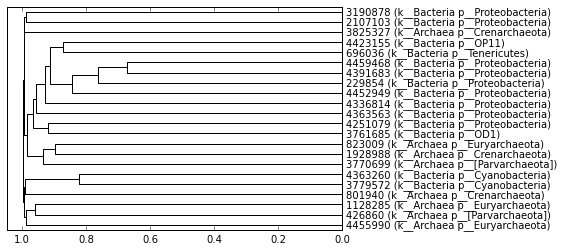

In [5]:
guide_lm = average(kmer_distances.condensed_form())
guide_d = dendrogram(guide_lm, labels=kmer_distances.ids, orientation='right', 
                     link_color_func=lambda x: 'black')

In [6]:
from skbio import TreeNode

In [7]:
guide_tree = TreeNode.from_linkage_matrix(guide_lm, kmer_distances.ids)

And then do progressive alignment

In [8]:
from skbio.alignment import global_pairwise_align_nucleotide

def progressive_msa(query_sequences, guide_tree, pairwise_aligner=global_pairwise_align_nucleotide):
    # we need a parallel implementation of this functionality, and a Cython/C global aligner that can handle 
    # alignment of alignments. If done right, it could have a big impact on the field. Contact 
    # gregcaporaso@gmail.com if you have any interest in working on this. 
    c1, c2 = guide_tree.children
    if c1.is_tip():
        c1_aln = query_sequences[c1.name]
    else:
        c1_aln = progressive_msa(query_sequences, c1, pairwise_aligner)

    if c2.is_tip():
        c2_aln = query_sequences[c2.name]
    else:
        c2_aln = progressive_msa(query_sequences, c2, pairwise_aligner)
        
    return pairwise_aligner(c1_aln, c2_aln)[0]
    


In [9]:
msa = progressive_msa(sequences, guide_tree)

/home/evan/biocore/scikit-bio/skbio/alignment/_pairwise.py:599: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


We can next build a tree from this multiple sequence alignment. To do that, we'll first compute the Hamming distances between the sequences, and then pass the resulting ``DistanceMatrix`` to the ``average`` function (for now this is a UPGMA tree, in the future, we'll update to use skbio's neighbor joining function).

In [10]:
from skbio.sequence.distance import hamming
msa_distances = DistanceMatrix.from_iterable(msa, metric=hamming, key='id')

/home/evan/.conda/envs/skbio/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


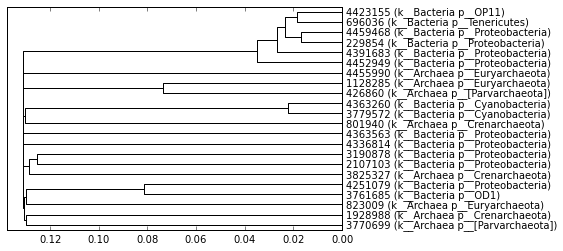

In [11]:
lm = average(msa_distances.condensed_form())
d = dendrogram(lm, labels=msa_distances.ids, orientation='right', 
               link_color_func=lambda x: 'black')